# CNTL composite first mode and second mode

## import package

In [1]:
import sys
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

sys.path.append('/home/b11209013/Package/')
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## load data

In [2]:
pc_path  = '/work/b11209013/2024_Research/MPAS/PC/'
q1_fname = '/work/b11209013/2024_Research/MPAS/merged_data/CNTL/q1.nc'

var_list = ['tpc1', 'tpc2', 'qvpc1', 'qvpc2']

pc_data = {}

# CNTL Q1 information
with nc.Dataset(q1_fname, 'r', mmap=True) as f:
    lat  = f.variables['lat'][:]
    lon  = f.variables['lon'][:]
    lev  = f.variables['lev'][:]
    time = f.variables['time'][:]
    
    lat_lim = np.where((lat >= -5) & (lat <= 5))[0]
    q1   = f.variables['q1'][:, :, lat_lim, :]
print(q1.shape)
# CNTL principal components
with nc.Dataset(f"{pc_path}CNTL_PC.nc", 'r', mmap=True) as f:
    lat = f.variables['lat'][:]
    lon = f.variables['lon'][:]
    time = f.variables['time'][:]
    
    for var in var_list:
        pc_data[var] = f.variables[var][:]

# 

# EOF structure
EOF = np.loadtxt(f'{pc_path}CNTL_EOF.txt')

lev_itp = np.linspace(150, 1000, 18)

eof1 = (EOF[:, 0]).reshape((-1, 1))
eof2 = (EOF[:, 1]).reshape((-1, 1))

FileNotFoundError: [Errno 2] No such file or directory: '/work/b11209013/MPAS/merged_data/CNTL/q1.nc'

## Select Kelvin wave positive anomaly

### Vertical integrated Q1

In [3]:
q1_ave = (q1[:, 1:] + q1[:, :-1])/2
q1_vint = np.sum(q1_ave * np.diff(lev)[None, :, None, None], axis=1)*86400/9.8/2.5e6

### Process data

In [4]:
# symmetric
fmt = dp.Format(lat)

q1_sym = fmt.sym(q1_vint)

# Compute FFT and Reconstruct

## wavenumber and frequency
wn = np.linspace(-360, 360, 720)
fr = np.linspace(-2, 2, 376)

wnm, frm = np.meshgrid(wn, fr)

## Kelvin Dispersion Relation
kelvin_dispersion = lambda ed, k: 86400/(2*np.pi*6.371e6)*np.sqrt(9.81*ed)*k

## Kelvin Wave Band
kelvin_condition = (
    (wnm>=1) & (wnm<=14) &
    (frm>=1/20) & (frm<=1/2.5) &
    (frm<=kelvin_dispersion(90, wnm)) & (frm>=kelvin_dispersion(8, wnm))
    )

q1_fft = np.fft.fftshift(np.fft.fft2(q1_sym))[:, ::-1]
q1_fft = np.where(kelvin_condition, q1_fft*2, 0)

## inverse FFT
q1_recon = np.fft.ifft2(np.fft.ifftshift(q1_fft[:, ::-1])).real

ref_tseries = q1_recon[:, 5]

pos_idx = np.where(ref_tseries > (ref_tseries.mean()+ref_tseries.std()))[0]
print(pos_idx)

## Construct Profile with Linear Response Function

In [5]:
# design specific time series
time_idx = list(np.linspace(0, 40 ,41, dtype=int))

print(time_idx)

# select PC information in the time series
pc_sel = {
    var: pc_data[var][time_idx, :, :]
    for var in var_list
} # time: 6; lat:20; lon = 720;

# symmetrize the PC data and select specific longitude
pc_sym = {
    var: fmt.sym(pc_sel[var])[:, 5].reshape((-1, 41))
    for var in var_list
}

# project to corresponding EOF

pc_pt = {
    'tpc1': eof1 @ pc_sym['tpc1'],
    'tpc2': eof2 @ pc_sym['tpc2'],
    'qvpc1': eof1 @ pc_sym['qvpc1'],
    'qvpc2': eof2 @ pc_sym['qvpc2']
}

# construct state vector
state_vec = {
    'pc1': np.concatenate([pc_pt['tpc1'], pc_pt['qvpc1']], axis=0),
    'pc2': np.concatenate([pc_pt['tpc2'], pc_pt['qvpc2']], axis=0)
}



[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40)]


### load linear response function

In [14]:
import joblib

lrf_path = '/home/b11209013/2024_Research/MPAS/LRF/LRF_file/'

lrf = joblib.load(f'{lrf_path}lrf_CNTL.pkl')

lw_lrf = lrf['lw_lrf']
sw_lrf = lrf['sw_lrf']
cu_lrf = lrf['cu_lrf']

print(lw_lrf.shape)

(19, 38)


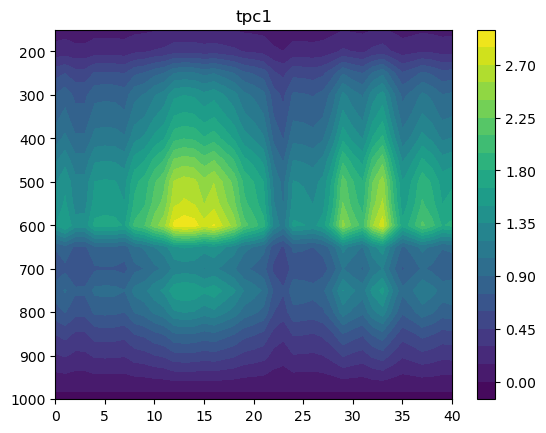

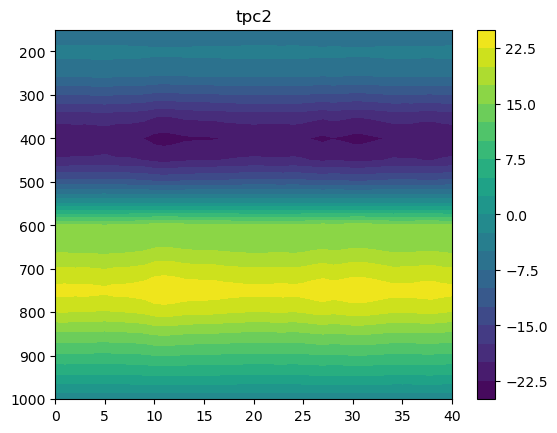

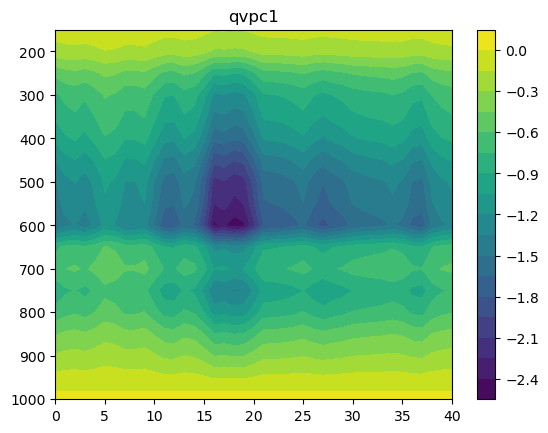

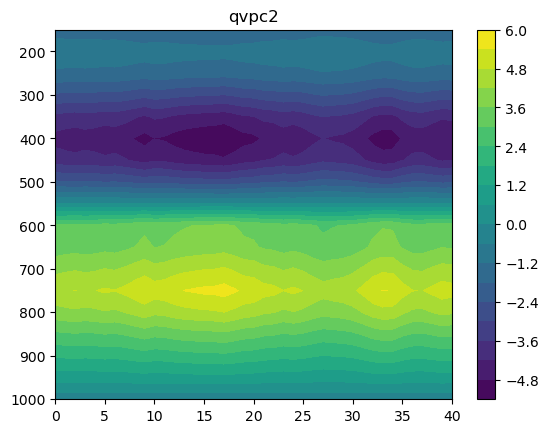

In [7]:
x = np.linspace(0, 40, 41)

plt.contourf(x, lev_itp, pc_pt['tpc1'], levels=20)
plt.ylim([1000, 150])
plt.title('tpc1')
plt.colorbar()
plt.show()

plt.contourf(x, lev_itp, pc_pt['tpc2'], levels=20)
plt.ylim([1000, 150])
plt.title('tpc2')
plt.colorbar()
plt.show()

plt.contourf(x, lev_itp, pc_pt['qvpc1'], levels=20)
plt.ylim([1000, 150])
plt.title('qvpc1')
plt.colorbar()
plt.show()

plt.contourf(x, lev_itp, pc_pt['qvpc2'], levels=20)
plt.ylim([1000, 150])
plt.title('qvpc2')
plt.colorbar()
plt.show()


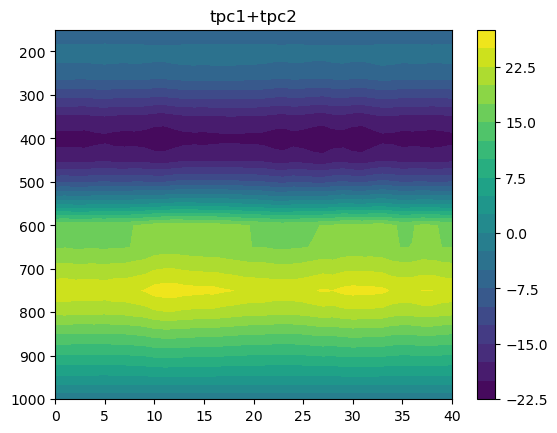

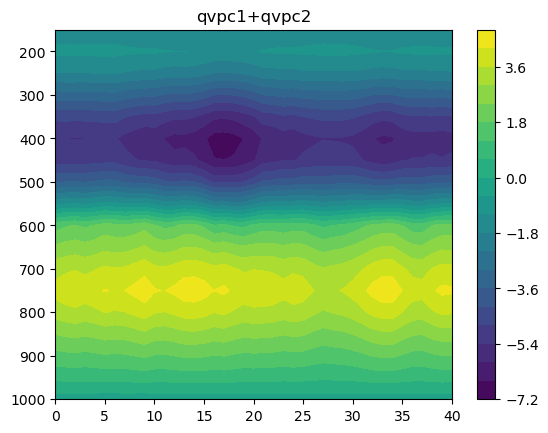

In [8]:
plt.contourf(x, lev_itp, pc_pt['tpc1']+pc_pt['tpc2'], levels=20)
plt.ylim([1000, 150])
plt.title('tpc1+tpc2')
plt.colorbar()
plt.show()

plt.contourf(x, lev_itp, pc_pt['qvpc1']+pc_pt['qvpc2'], levels=20)
plt.ylim([1000, 150])
plt.title('qvpc1+qvpc2')
plt.colorbar()
plt.show()